In [3]:
#!pip install -U --pre segmentation-models --user
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [2]:
import os
import random

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm

import datasets
import preprocessing

In [3]:
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

MASK_DIR = 'data/train/mask'
PREDICTION_DIR = 'data/test/mask'

In [5]:
#preprocessing.create_masks_from_json()

## Create train/val split of dataset indexes

In [4]:
ids = os.listdir(preprocessing.mask_dir)
random.shuffle(ids)
split = int(0.7 * len(ids))
train_frames = ids[:split]
val_frames = ids[split:]

In [5]:
len(train_frames), len(val_frames)

(182, 79)

# Look at the data

In [6]:
def visualize_with_overlay(image, bacteria_mask):
    plt.figure(figsize=(16, 5))
    plt.subplot(1,2,1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.xticks([]); plt.yticks([])
    plt.imshow(image)
    plt.imshow(bacteria_mask, 'brg', interpolation='none', alpha=0.4)
    plt.show()

(512, 640, 3) (512, 640, 1)


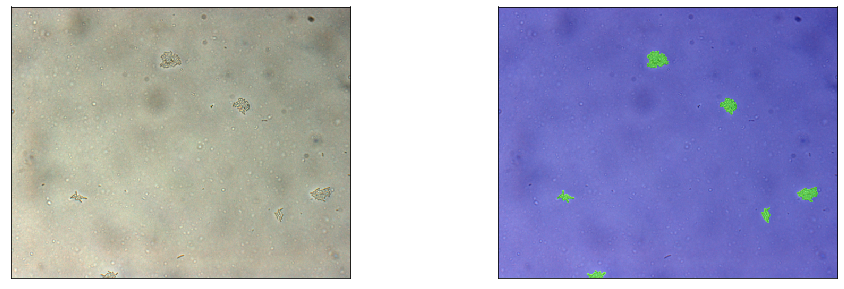

In [7]:
data = datasets.SegmentationTrainDataset(TRAIN_DIR, MASK_DIR, ids)
image, mask = data[random.randint(0, len(ids))]
print(image.shape, mask.shape)

visualize_with_overlay(image, mask.squeeze())

## Augmentations

In [8]:
import albumentations as A

In [9]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)


def get_training_augmentation():
    train_transform = [
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0.1, shift_limit=0.1, p=1, border_mode=0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_preprocessing():    
    _transform = [
        A.Normalize()
    ]
    return A.Compose(_transform)

(512, 640, 3) (512, 640, 1)


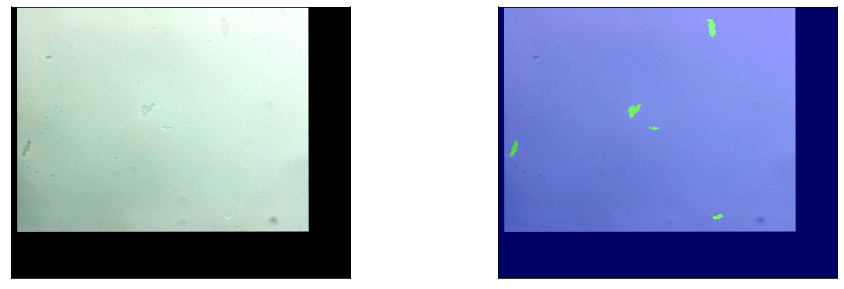

In [10]:
data = datasets.SegmentationTrainDataset(TRAIN_DIR, MASK_DIR, ids,
                                         augmentation=get_training_augmentation())

image, mask = data[random.randint(0, len(ids))]
print(image.shape, mask.shape)

visualize_with_overlay(image, mask.squeeze())

# Transfer learning

In [12]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, dataset, batch_size=32, dim=(512,640), shuffle=True):

        self.dim = dim
        self.batch_size = batch_size
        self.dataset = dataset
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_samples = [self.dataset[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_samples)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_samples):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3))
        y = np.empty((self.batch_size, *self.dim, 1), dtype=int)

        # Generate data
        for i, sample in enumerate(list_samples):

            X[i,] = list_samples[i][0]
            y[i,] = list_samples[i][1]

        return X, y

In [11]:
def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [11]:
BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [12]:
BATCH_SIZE = 4
EPOCHS = 60

In [14]:
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid')

In [25]:
optimizer = keras.optimizers.Adam()

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.9), sm.metrics.FScore(threshold=0.9)]

In [26]:
model.compile(optimizer, total_loss, metrics)

In [17]:
train_dataset = datasets.SegmentationTrainDataset(
    TRAIN_DIR,
    MASK_DIR,
    train_frames,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

valid_dataset = datasets.SegmentationTrainDataset(
    TRAIN_DIR,
    MASK_DIR,
    val_frames,
    augmentation=None, 
    preprocessing=get_preprocessing(preprocess_input),
)

In [18]:
train_dataloader = DataGenerator(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataGenerator(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint('models/model_seg.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader) // BATCH_SIZE,
    epochs=EPOCHS, 
    callbacks=callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/60
11/11 [==============================] - 538s 49s/step - loss: 1.0187 - iou_score: 0.0958 - f1-score: 0.1570 - val_loss: 5.7990 - val_iou_score: 0.0252 - val_f1-score: 0.0480
Epoch 2/60
11/11 [==============================] - 477s 43s/step - loss: 0.9061 - iou_score: 0.5718 - f1-score: 0.7221 - val_loss: 4.7753 - val_iou_score: 0.0365 - val_f1-score: 0.0678
Epoch 3/60
11/11 [==============================] - 482s 44s/step - loss: 0.8355 - iou_score: 0.6624 - f1-score: 0.7946 - val_loss: 6.0543 - val_iou_score: 0.0203 - val_f1-score: 0.0395
Epoch 4/60
11/11 [==============================] - 470s 43s/step - loss: 0.5725 - iou_score: 0.7001 - f1-score: 0.8200 - val_loss: 2.1320 - val_iou_score: 0.1089 - val_f1-score: 0.1898
Epoch 5/60
11/11 [==============================] - 472s 43s/step - loss: 0.4991 - iou_score: 0.7213 - f1-score: 0.8344 - val_loss: 0.7950 - val_iou_score: 0.4294 - val_f1-score: 0.5713
Epoch 6/60
11/11 [==============================] - 487s 44s/step - lo

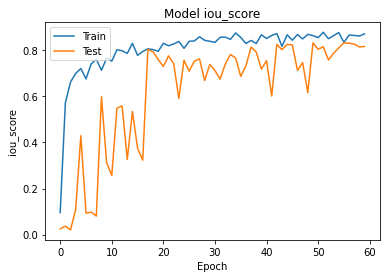

In [ ]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

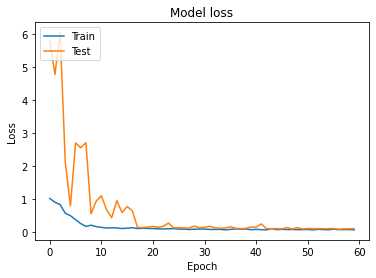

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [19]:
model.load_weights('models/best_model_seg.h5') 

In [20]:
test_dataset = datasets.SegmentationTestDataset(
    TEST_DIR,
    preprocessing=get_preprocessing(preprocess_input)
)

In [21]:
len(test_dataset)

107

## Visualization of results on test dataset

In [31]:
def visualize_results(n_samples, threshold):
    
    ids = np.random.choice(np.arange(len(test_dataset)), size=n_samples)
    
    for i in ids:
        
        image = np.expand_dims(test_dataset[i], axis=0)
        pr_mask = np.where(model.predict(image) >= threshold, 1, 0).squeeze()
        
        visualize_with_overlay(
            image=cv2.imread(test_dataset.images_fps[i], cv2.COLOR_BGR2RGB),
            bacteria_mask=pr_mask
        )

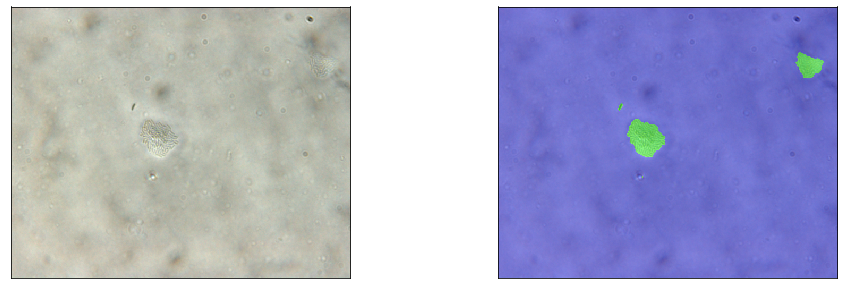

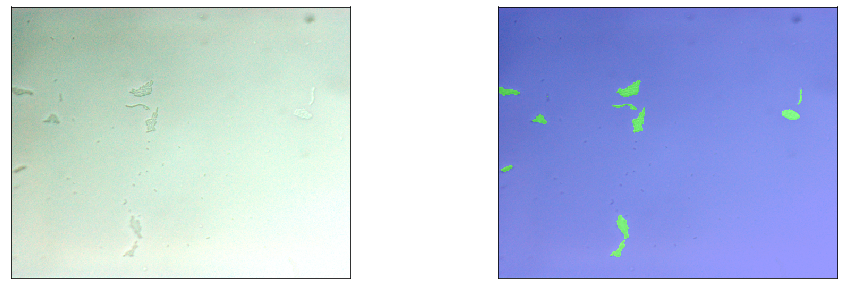

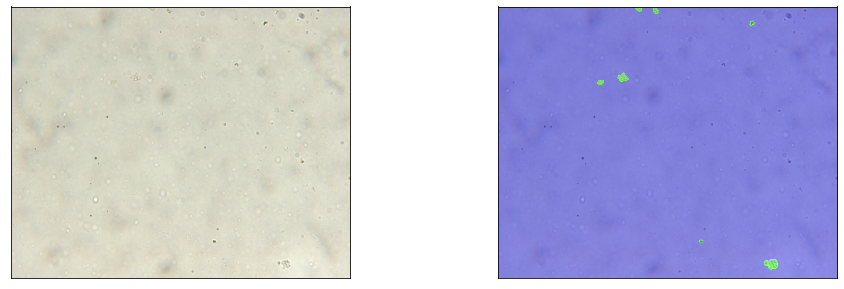

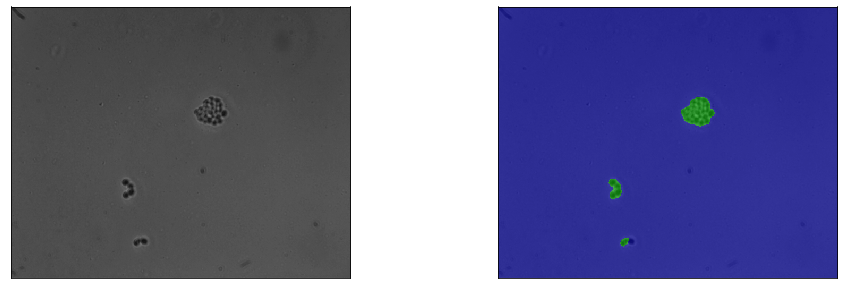

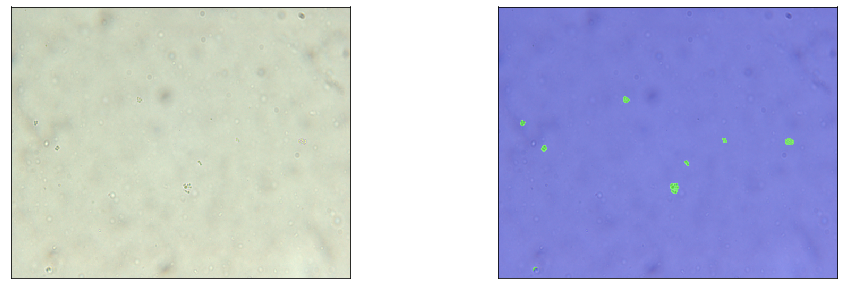

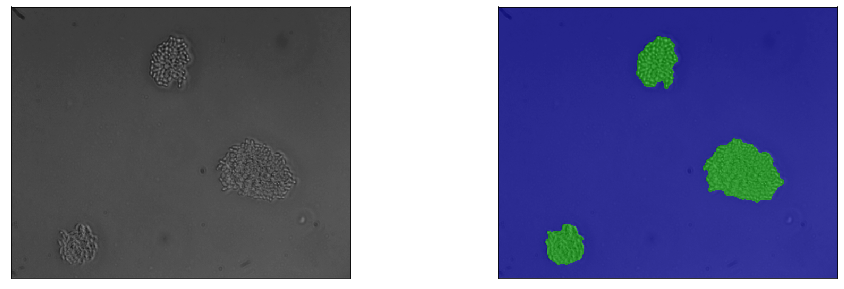

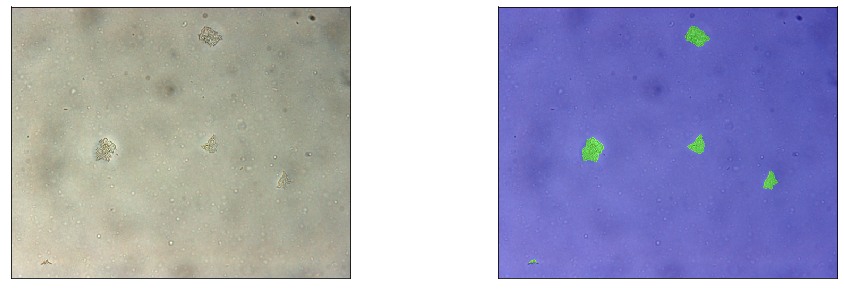

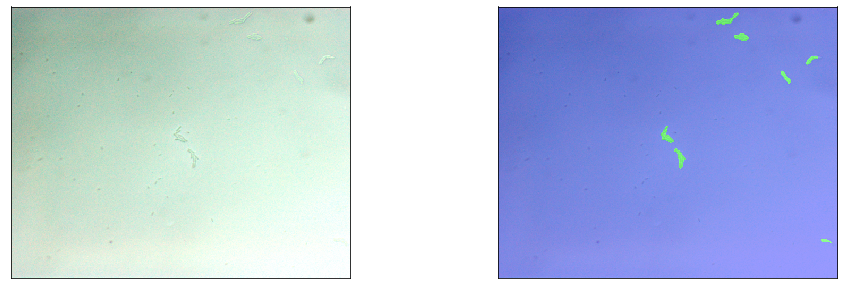

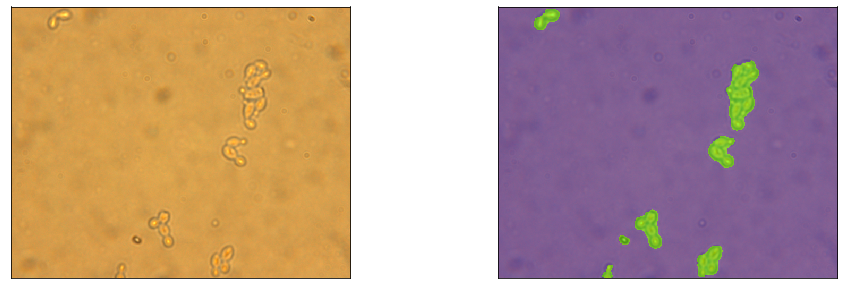

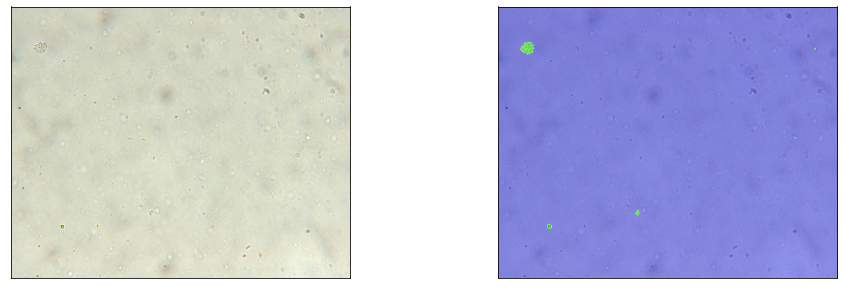

In [30]:
threshold = 0.95
n = 10

visualize_results(n, threshold)

## Make predictions

In [43]:
def make_predictions(threshold):
    
    for index, sample in enumerate(test_dataset):
        
        image = np.expand_dims(sample, axis=0)
        predicted_mask = np.where(model.predict(image) > threshold, 1, 0).squeeze()
        
        save_path = os.path.join(PREDICTION_DIR, test_dataset.ids[index])
        plt.imsave(save_path, predicted_mask)

In [44]:
if 'mask' not in os.listdir(TEST_DIR):
    os.mkdir(PREDICTION_DIR)

In [45]:
%%time
threshold = 0.95
make_predictions(threshold)

Wall time: 3min 11s
